In [1]:
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap, jacfwd, jacrev
from jax import random
from jax.ops import index_update
import matplotlib.pyplot as plt

import astropy.io.fits as pf
import xaosim as xs
from xaosim.pupil import HST_NIC1 as HST
from scipy.ndimage import rotate

from time import time as clock
from tqdm import tqdm_notebook as tqdm
import morphine

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

import warnings
warnings.filterwarnings("ignore")


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/benjaminpope/pysynphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


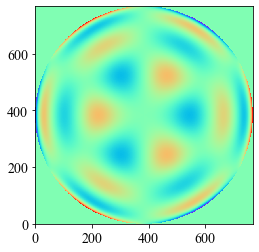

In [2]:
NZ = 50
PPSZ = 256
PSZ = 256*3

zernikes = morphine.zernike.zernike_basis(NZ,npix=PSZ,outside=0.0)
plt.imshow(zernikes[-3,:,:],cmap=phasemap)


In [3]:
coefficients = onp.random.randn(NZ)

In [4]:
def make_mode(coeff):
    return np.dot(coeff,zernikes.reshape(NZ,PSZ*PSZ)).reshape(PSZ,PSZ)

In [5]:
mode = make_mode(coefficients)

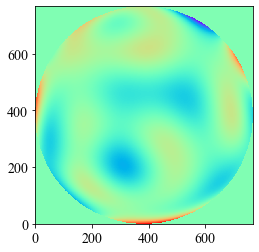

In [6]:
plt.imshow(mode,cmap=phasemap)

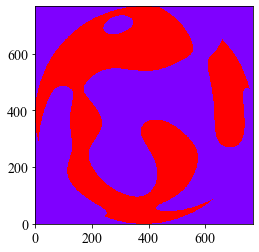

In [7]:
plt.imshow(mode>0,cmap=phasemap)

In [8]:
x0, y0 = 0.3, 0.6

npix = 50
xx, yy = np.meshgrid(np.linspace(0,1,npix),np.linspace(0,1,npix))
rr = np.sqrt((xx-x0)**2 + (yy-y0) **2) 

vignette = np.exp(-(rr/0.25)**3)
vignette /= np.max(vignette)
vignette = 30*xx+5*yy -12

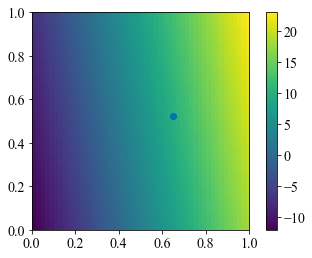

In [9]:
@jit
def normalize(vignette):
    return (vignette-np.min(vignette))/(np.max(vignette)-np.min(vignette))

@jit
def centroid(vignette):
    vv = normalize(vignette)
    xx, yy = np.meshgrid(np.linspace(0,1,vignette.shape[0]),np.linspace(0,1,vignette.shape[1]))
    return np.sum(vv*xx)/np.sum(vv),np.sum(vv*yy)/np.sum(vv)

plt.imshow(vignette,extent=[0,1,0,1])
plt.colorbar()
plt.scatter(centroid(vignette)[0],centroid(vignette)[1])

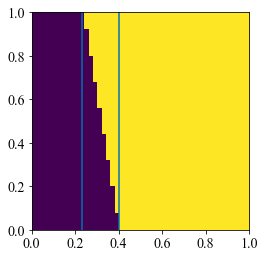

In [10]:
plt.imshow((vignette)>0,extent=[0,1,0,1])
plt.axvline(0.233)
plt.axvline(0.39999917)

In [11]:
def lsq_params(img):
    xx, yy = np.meshgrid(np.linspace(0,1,img.shape[0]),np.linspace(0,1,img.shape[1]))
    A = np.vstack([xx.ravel(), yy.ravel(), np.ones_like(xx).ravel()]).T
    matrix = np.linalg.inv(np.dot(A.T,A)).dot(A.T)
    return matrix, xx, yy, A

@jit
def lsq(img):
    return np.dot(matrix,img.ravel())

def area(img):
    #line of nodes: ax + by + c = 0
    # y = -c/b -(a/b)x
    # indefinite integral is (-c/b)x -(a/2b)x**2
    # so area under curve from 0 to 1 is (-c/b -a/2b)
    # but at y = 1: ax + b + c = 0
    # x_1 = (-b-c)/a
    # at y = 0: ax + c = 0 -> x_2 = -c/a
    if np.all(img>0):
        return 1.
    elif np.all(img<0):
        return 0.
    else:
        a,b,c = lsq(img)
        
        x1 = (-b-c)/a
        x2 = -c/a
        x1, x2 = np.min([x1,x2]), np.max([x1,x2])
        x1, x2 = np.max([x1,0]), np.min([x2,1])

        dummy = x1 + (-c/b)*x2-(0.5*a/b)*x2**2 - (-c/b)*x1+(0.5*a/b)*x1**2
        positive = np.mean(img)>0 # 1 if positive, 0 if negative
        if dummy > 0.5:
            dummy = 1-dummy
        if positive:
            return (1-dummy)
        else:
            return dummy
        
@jit
def jit_area(img):
    #line of nodes: ax + by + c = 0
    # y = -c/b -(a/b)x
    # indefinite integral is (-c/b)x -(a/2b)x**2
    # so area under curve from 0 to 1 is (-c/b -a/2b)
    # but at y = 1: ax + b + c = 0
    # x_1 = (-b-c)/a
    # at y = 0: ax + c = 0 -> x_2 = -c/a
#     binary = np.where(np.all((img<0))+np.all((img>0)),1,0)
#     if np.all(img>0):
#         return 1.
#     elif np.all(img<0):
#         return 0.
#     else:
    a,b,c = lsq(img)
    a, b, c = np.where(a==0,1e-15,a), np.where(b==0,1e-15,b), np.where(c==0,1e-15,c)
    x1 = (-b-c)/(a) # don't divide by zero
    x2 = -c/(a) # don't divide by zero
    x1, x2 = np.min([x1,x2]), np.max([x1,x2])
    x1, x2 = np.max([x1,0]), np.min([x2,1])

    dummy = x1 + (-c/b)*x2-(0.5*a/b)*x2**2 - (-c/b)*x1+(0.5*a/b)*x1**2
    positive = np.mean(img)>0 # 1 if positive, 0 if negative
    dummy = np.where(dummy>=0.5,dummy,1-dummy)
    dummy = np.where(np.mean(img)>=0,dummy,1-dummy)
    dummy = np.where(np.all(img>0),1,dummy)
    dummy = np.where(np.all(img<=0),0,dummy)
    dummy = np.where(np.any(img==0),np.mean(dummy>0),dummy)
    dummy = np.where(np.all(img==0),0,dummy)

    dummy = np.where(dummy>1,1,dummy)
    dummy = np.where(dummy<0,0,dummy) # godawful hacks, jesus christ
    return dummy

In [12]:
matrix, xx, yy, A = lsq_params(vignette)

a, b, c = lsq((vignette))
print(a,b,c)

29.999971 4.999959 -11.999964


In [13]:
%%timeit
lsq(vignette)

77.7 µs ± 980 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%%timeit
jit_area(vignette)

93.1 µs ± 24.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


-23.333332 12.222225


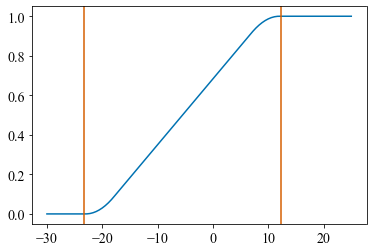

In [15]:
down = np.linspace(-30,25,100)
thresh = []
cxx, cyy = [],[]
for d in down:
    thresh.append(jit_area(vignette+d))
    cen = centroid(vignette+d)
    cxx.append(cen[0])
    cyy.append(cen[1])
thresh = np.array(thresh)
plt.plot(down,thresh)
lower, upper = np.max(np.where(thresh==0)), np.min(np.where(thresh==1))
print(down[lower],down[upper])
plt.axvline(down[lower],color=colours[2])
plt.axvline(down[upper],color=colours[2])

In [16]:
test = np.array(mode.split(PPSZ))
test = np.array(test.split(PPSZ,axis=2))


In [17]:
%%time
# def soft_thresh(array):
dummy = np.array(mode.split(PPSZ))
dummy = np.array(dummy.split(PPSZ,axis=2))

output = np.zeros((PPSZ,PPSZ))
subarray = dummy[0,0,:,:]
matrix, xx, yy, A = lsq_params(subarray)


CPU times: user 187 ms, sys: 25.3 ms, total: 212 ms
Wall time: 173 ms


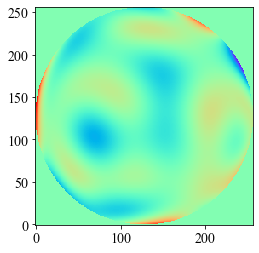

In [18]:
plt.imshow(dummy[:,:,0,0],cmap=phasemap)


In [19]:
flat = dummy.reshape(PPSZ*PPSZ,3,3)

In [20]:
vmap_mask = (vmap(jit_area,in_axes=(0)))
masked = vmap_mask(flat)

In [21]:
print('Too low:',np.sum(masked<0),'; Too High: ',np.sum(masked>1))

Too low: 0 ; Too High:  0


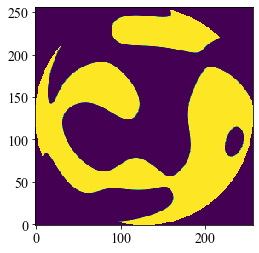

In [22]:
plt.imshow(vmap_mask(flat).reshape(256,256),vmin=0,vmax=1)

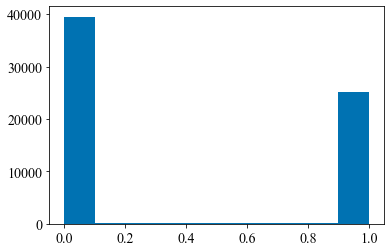

In [23]:
plt.hist(vmap_mask(flat).flatten());

In [24]:
%%timeit 
vmap_mask(flat)

1.02 ms ± 63.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Now we can do soft edges, let's think about optimizing things!

In [25]:
pdiam = 1
ISZ = 128
PIXSCALE = 0.025
WAVELENGTH = 1.0e-6
ppscale = pdiam/PPSZ

def psf_from_zernikes(coefficients_sequence):

    toliman_new = morphine.CircularAperture(radius=pdiam/2)
    toliman_new.pupil_diam = pdiam

    aberrated = morphine.OpticalSystem(npix=PSZ)
    aberrated.add_pupil(toliman_new)    # pupil radius in meters
    aberrated.pupil_diameter = pdiam
    wf = aberrated.input_wavefront()

    thinlens = morphine.ZernikeWFE(radius=pdiam/2., coefficients=coefficients_sequence, cached_zernikes=zernikes)
    aberrated.add_pupil(thinlens)
    aberrated.add_detector( pixelscale=PIXSCALE*2, fov_arcsec=2.*ISZ*PIXSCALE )

    blur,intermediate = aberrated.propagate_mono(WAVELENGTH,normalize='first')
    return blur.intensity

In [26]:
coefficients=np.zeros(NZ)

In [27]:
psf = psf_from_zernikes(coefficients)

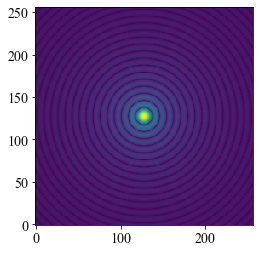

In [28]:
plt.imshow(psf**0.25)

In [29]:
dummy = np.array(mode.split(PPSZ))
dummy = np.array(dummy.split(PPSZ,axis=2))

subarray = dummy[0,0,:,:]
matrix, xx, yy, A = lsq_params(subarray)
vmap_mask = jit(vmap(jit_area,in_axes=(0)))

@jit
def binary_mask(coefficients):
    mode = make_mode(coefficients)
    dummy = np.array(mode.split(PPSZ))
    dummy = np.array(dummy.split(PPSZ,axis=2))
    flat = dummy.reshape(PPSZ*PPSZ,3,3)
    return vmap_mask(flat).reshape(PPSZ,PPSZ)

In [30]:
%%timeit
binary_mask(coefficients)

145 µs ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
circle = morphine.CircularAperture(radius=pdiam/2)
circle.pupil_diam = pdiam

def osys_from_binary(coefficients_sequence):
    
    binary = binary_mask(coefficients_sequence)

    aberrated = morphine.OpticalSystem(npix=PPSZ)
    aberrated.pupil_diameter = pdiam

    binary_pupil = morphine.ArrayOpticalElement(opd=binary*np.pi*WAVELENGTH,
                               transmission=np.ones_like(binary),
                               pixelscale=ppscale,
                               name='mask',planetype=1)
    
    aberrated.add_pupil(circle)
    aberrated.add_pupil(binary_pupil)    # pupil radius in meters
    aberrated.add_detector(pixelscale=PIXSCALE*2, fov_arcsec=2.*ISZ*PIXSCALE )
    return aberrated

def psf_from_binary(coefficients_sequence):
    aberrated = osys_from_binary(coefficients_sequence)
    blur,intermediate = aberrated.propagate_mono(WAVELENGTH,normalize='first')
    return blur.intensity,intermediate

In [32]:
opys = osys_from_binary(coefficients)

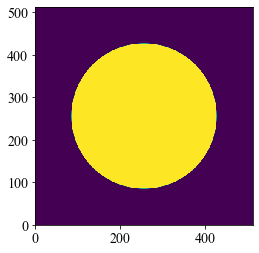

In [33]:
wf = opys.input_wavefront()
test = opys.planes[0].sample(wf)
plt.imshow(test)

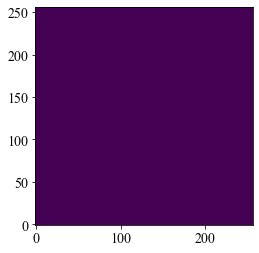

In [34]:
plt.imshow(opys.planes[1].opd)

In [35]:
coefficients = onp.random.randn(NZ)
coefficients2 = onp.random.randn(NZ)


###  Now let's autodiff

In [36]:
psf,intermediate = psf_from_binary(coefficients)

In [37]:
jac_binary = jacfwd(binary_mask)

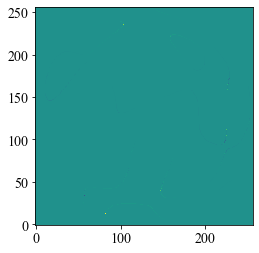

In [38]:
test = jac_binary(coefficients)
plt.imshow(test[:,:,5]!=0)

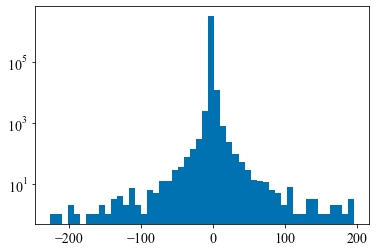

In [39]:
plt.hist(test.ravel(),bins=50);
plt.yscale('log')

### OK! So we can differentiate the making of a phase mask through the coefficients

In [40]:
# @jit
def objective_function_zernike(coefficients):
    psf = psf_from_zernikes(coefficients)
    return np.max(psf)

print(objective_function_zernike(coefficients))

grad_obj = (grad(objective_function_zernike))
print(grad_obj(coefficients))

3.1963214e-07
[-0.02253228  0.27102062 -0.02079984  0.5013303   0.42706555  0.24072245
  1.4902108   1.1286254   1.2567453   0.4790423   0.9404962  -0.89261776
  0.5553671  -0.2628975   0.6571748  -1.487835    0.03395711 -0.08961809
  0.68167716 -0.7842555   1.0971906  -0.72218287 -0.57678324  1.1173987
 -0.22407083 -0.52575564  0.37265512 -0.68239915  0.39269227  0.14480571
  0.72634053  2.6242669  -0.2498992   0.74343985  1.6658857  -0.0674248
 -0.05338989 -0.50187767  0.39170864  0.69951737 -0.5758411  -0.37243614
 -0.15594529 -0.42152625  0.26641434  0.30892277 -0.43830296 -0.12172323
 -0.3215631  -0.11115436]


In [41]:
from jax.config import config
config.update("jax_debug_nans", True)

In [46]:
# @jit
def objective_function_binary(coefficients_sequence):
    psf,intermediate = psf_from_binary(coefficients_sequence)
    return np.std(psf)

print(objective_function_binary(coefficients))

grad_obj = jit(grad(objective_function_binary))
print(grad_obj(coefficients))

0.0002283339
[-2.5029334e-05  1.6567374e-06 -2.1693631e-06  4.9697878e-06
 -1.4676752e-06  2.4383917e-07 -4.3804044e-05  2.7583361e-05
  7.6635799e-05 -1.5726095e-05 -3.5972844e-05 -4.4674678e-05
 -4.0648265e-05 -8.1334374e-06  1.5979864e-05  1.2195970e-05
  6.4260981e-05  3.8388011e-06 -3.8968752e-05 -1.8050419e-05
  2.4894511e-05  4.6502471e-05 -1.6640166e-05 -2.9284010e-05
 -3.9469545e-05  3.1649532e-05 -3.2988912e-05  1.3408891e-05
  7.3070532e-07  4.7539877e-05 -1.6537797e-06  2.0018066e-05
  3.2428070e-05  3.0617768e-05 -4.1115152e-07 -2.4661527e-05
 -2.8400540e-05 -4.1498151e-07  2.1619169e-05 -5.8910309e-06
 -3.1916326e-05  2.5388865e-05  1.9227915e-05  2.1265023e-05
  2.7588208e-05 -3.7274345e-05  1.8692910e-05  3.2642849e-06
  2.0445201e-05 -9.2939827e-06]


In [43]:
%%timeit
grad_obj(coefficients)

364 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
# factors = np.linspace(0.01,100,100)
# objs = []
# for factor in tqdm(factors):
#     test_coef = onp.copy(coefficients)
#     test_coef[5] *= factor
#     test_coef[15] /= factor
#     objs.append(objective_function_binary(test_coef))
# objs = np.array(objs)
# plt.plot(factors,objs)

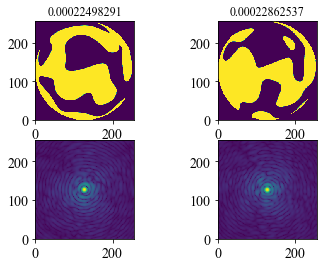

In [49]:
factors = [0.1,2]
objs = []
fig, axes = plt.subplots(2,2)
for j, factor in enumerate(factors):
    test_coef = onp.copy(coefficients)
    test_coef[5] *= factor
    test_coef[15] /= factor
    mask = binary_mask(test_coef)
    psf,intermediate = psf_from_binary(test_coef)
    axes[0,j].imshow(mask)
    axes[0,j].set_title(objective_function_binary(test_coef))
    
    axes[1,j].imshow(psf**0.25)


### Now for gradient descent!

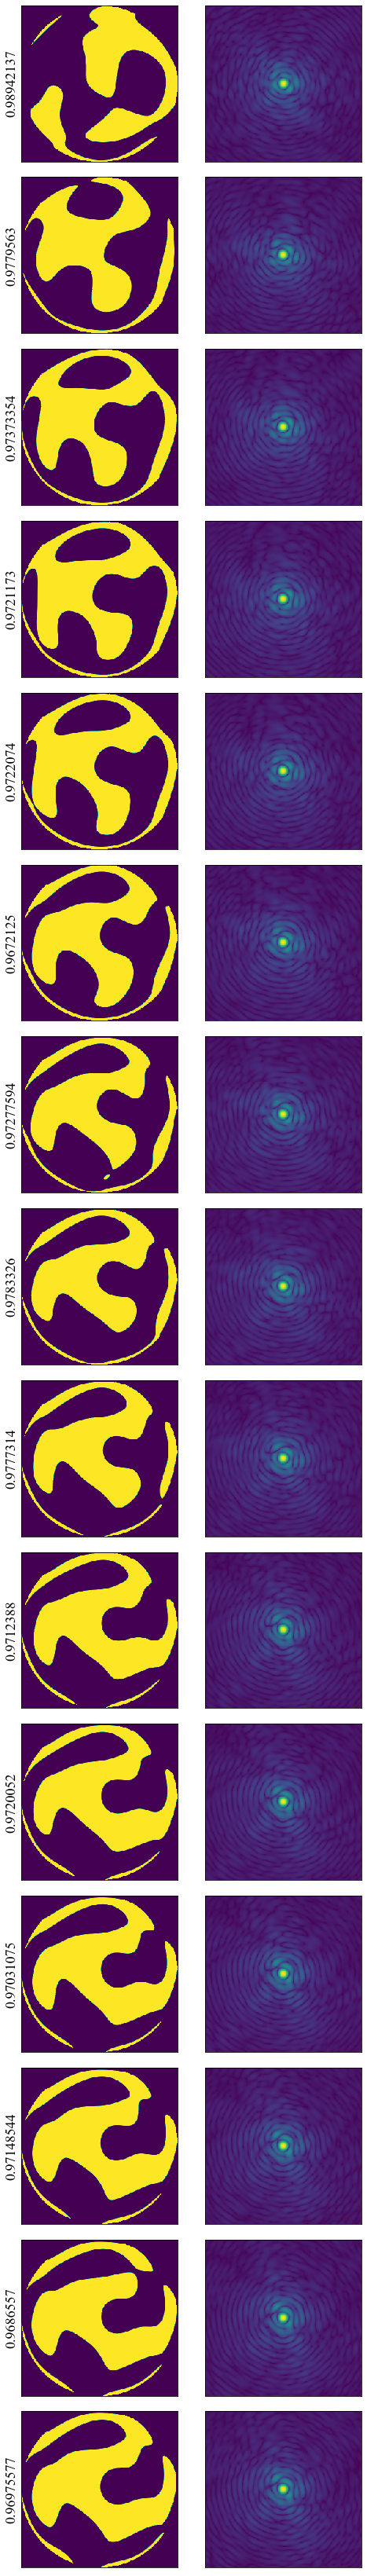

In [68]:
nstages = 15
fig, axes = plt.subplots(nstages,2,figsize=(8,nstages*4))
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(wspace=0.1,hspace=0.1)

coefficients = onp.random.randn(NZ)
norm = objective_function_binary(coefficients)
objs = []
k = 0
for j in tqdm(range(nstages*10)):
    coefficients -= 1e5*grad_obj(coefficients)
    obj = objective_function_binary(coefficients)
    objs.append(obj)
    if j%10 == 0:
        mask = binary_mask(coefficients)
        psf,intermediate = psf_from_binary(coefficients)
        axes[k,0].imshow(mask)
        axes[k,1].imshow(psf**0.25)
        axes[k,0].set_ylabel(obj/norm)
        k+=1
objs = np.array(objs)

Text(0.5, 0, 'Epoch')

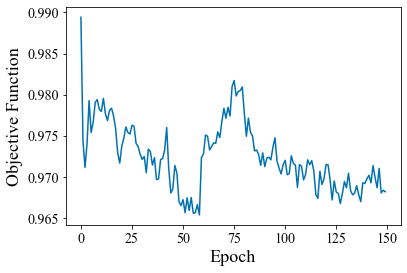

In [69]:
plt.plot(objs/norm)
plt.ylabel('Objective Function')
plt.xlabel('Epoch')